# 运用公开住宅出租挂牌数据进行住宅租金预测

此脚本适用于使用xgboost0.82和0.90版本的同学：由于xgboost模型0.81版本和0.82及以上版本差距较大，训练出来的模型相对重要性会有非常大的差距，因此，此版本代码根据0.82版本的模型的训练结果，更新了模型优化策略，修改了样例结果。

### 数据来源：

* 上海在租房源信息

* 时间节点：2019年7月17日

* 数据集包括在线租房源信息及其基本情况

* 属性信息：楼盘名称；租赁方式；面积；朝向；房租；城市；区域；街道或片区；地址；公交站等

### 学习目标：

#### 1）探索查看真实房源数据，找一找数据存在哪些问题？

* 要求：

  ① 读取一个真实房源的数据表
  
  ② 查看已有的数据存在哪些问题，确认数据应该如何清洗
  
#### 2）针对数据存在的问题，应该采取怎么样的数据清洗策略？

* 要求：

  ① 根据上一节发现的数据问题，编写数据清洗函数，并测试清洗函数
  
  ② 使用数据清洗函数对所有真实房源数据表进行处理并合并
  
  ③ 输出清洗合并后的数据表

#### 3）如何根据房源地理位置信息关联更多空间特征来提高租金模型的泛化能力？

* 要求：

  ① 利用已有的数据获取有效的样本地址信息
  
  ② 根据地址信息关联更多的空间特征
  
  ③ 输出关联了地理特征的完整模型数据表


#### 4）如何进行模型数据预处理？

* 要求：

  ① 以平米租金（单位：元/月/每平米)为应变量
  
  ② 处理模型数据中存在的缺失值、异常值问题
  
  ③ 输出最终的建模数据表

#### 5）选取不同的模型进行模型训练并对比模型效果、优化模型效果，确定最终预测模型

* 要求：

  ① 使用留一法进行数据集划分，验证集比例：30%
  
  ② 训练至少两个不同类型的模型进行租金模型训练，并对比模型效果
  
  ③ 优化模型效果，确定最佳模型，并保存模型文件


### 建议工作流程：

#### 1. 数据探索

#### 2. 数据清洗

#### 3. 特征补充

#### 4. 数据预处理

#### 5. 训练并优化模型

In [1]:
# **加载必要的模块**

# 基本模块：时间与路径
import os
import time
import string
# 数据读取与计算
import math
import pandas as pd
import numpy as np
# 绘图
import matplotlib.pyplot as plt
# 模型数据集划分
from sklearn.model_selection import train_test_split, KFold
# 模型流水线整合器
from sklearn.pipeline import Pipeline
# 模型数据预处理
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
# 模型
from sklearn.linear_model import LassoCV
import xgboost as xgb
# 加载回归模型的评价指标
from sklearn.metrics import mean_absolute_error
# 保存模型模块
from sklearn.externals import joblib 
# 屏蔽warnings
import warnings
warnings.filterwarnings('ignore') 

### 数据初探

查看数据的基本情况，发现数据存在的问题，针对问题制定下一步的数据处理计划

In [2]:
# 设置读取文件路径为脚本所在位置
# 读取文件
current_path = os.getcwd()
print(current_path)
data_path = os.path.join(current_path,'data', '租房信息a.csv')
df = pd.read_csv(open(data_path,encoding='utf-8'))
df.head()

C:\Users\wcd\租金实战forxgboost082andabove


,楼盘名称,租赁方式,户型,面积,朝向,房租,更新时间,采集时间,城市,区域,街道或片区,地段,地址,公交站,主图链接,楼盘详情链接,页面网址,标签
0,"鹏海小区,13号,线陈春路站,交通方便,商业地段,随时看房。",整租,2室1厅,65㎡,朝南,4500元/月,NaN,2019-07-17 19:34:54,上海,浦东,北蔡,鹏海东苑,浦东-北蔡-鹏海东苑,距13号线陈春路站约641米。,https://img.soufunimg.com/secondhouse/image/lo...,https://sh.zu.fang.com/chuzu/3_356163941_1.htm,https://sh.zu.fang.com/house-a025-b01646/,繁华地段/家电齐全/拎包入住
1,十六街区 欧式风格 南北通 拎包入住,整租,3室2厅,148㎡,朝南,14000元/月,NaN,2019-07-17 19:34:54,上海,浦东,北蔡,大华锦绣华城第19街区,浦东-北蔡-大华锦绣华城第19街区,距13号线下南路站约423米。,https://img.soufunimg.com/secondhouse/image/lo...,https://sh.zu.fang.com/chuzu/3_356381296_1.htm,https://sh.zu.fang.com/house-a025-b01646/,NaN
2,"莲宏苑,精装全配复式,三房两厅两卫,随时看房,期待来电",整租,3室1厅,124㎡,朝南,6800元/月,NaN,2019-07-17 19:34:54,上海,浦东,北蔡,莲宏苑,浦东-北蔡-莲宏苑,距13号线北蔡站约765米。,https://img.soufunimg.com/secondhouse/image/lo...,https://sh.zu.fang.com/chuzu/3_356095628_1.htm,https://sh.zu.fang.com/house-a025-b01646/,繁华地段/家电齐全/拎包入住
3,"万科海上传奇新出两房,一家人住优先!惜缺精装修全配,出租!",整租,2室2厅,92㎡,朝南,6500元/月,NaN,2019-07-17 19:34:54,上海,浦东,北蔡,万科海上传奇,浦东-北蔡-万科海上传奇,距11号线御桥站约376米。,https://img.soufunimg.com/secondhouse/image/lo...,https://sh.zu.fang.com/chuzu/3_325998408_1.htm,https://sh.zu.fang.com/house-a025-b01646/,全装全配/紧邻地铁/家电齐全
4,"13号。线。北蔡加东花园,全配,随时看房,期待来电",整租,2室2厅,89㎡,朝西,4800元/月,NaN,2019-07-17 19:34:54,上海,浦东,北蔡,通宇加东花园,浦东-北蔡-通宇加东花园,距13号线北蔡站约193米。,https://img.soufunimg.com/secondhouse/image/lo...,https://sh.zu.fang.com/chuzu/3_356116300_1.htm,https://sh.zu.fang.com/house-a025-b01646/,采光好/紧邻地铁/首次出租


In [3]:
print(f'数据维度：{df.shape}\n')
print(f'特征类型：\n{df.dtypes}')

数据维度：(20000, 18)

特征类型：
楼盘名称      object
租赁方式      object
户型        object
面积        object
朝向        object
房租        object
更新时间      object
采集时间      object
城市        object
区域        object
街道或片区     object
地段        object
地址        object
公交站       object
主图链接      object
楼盘详情链接    object
页面网址      object
标签        object
dtype: object


In [4]:
for var in ['租赁方式','户型','朝向']:
    print(f'<{var}>的分类别频数统计：\n{df[var].value_counts()}\n')

<租赁方式>的分类别频数统计：
整租       19066
合租主卧       520
合租次卧       231
整租㎡        161
合租单间        16
合租主卧㎡        5
合租次卧㎡        1
Name: 租赁方式, dtype: int64

<户型>的分类别频数统计：
2室2厅    4848
3室2厅    3907
2室1厅    3589
1室1厅    3026
3室1厅    1177
4室2厅    1137
1室0厅     603
2户合租     398
1室2厅     273
3户合租     262
4室3厅     166
5室3厅     124
5室2厅     121
4室1厅      67
4户合租      53
2室0厅      39
3室3厅      37
5户合租      35
7室1厅      19
1户合租      19
6室2厅      19
6室3厅      16
8室2厅      10
4室4厅      10
6室4厅       8
7室3厅       8
5室4厅       7
6户合租       6
7室2厅       5
2室3厅       5
0室1厅       3
1室3厅       1
8室3厅       1
3室0厅       1
Name: 户型, dtype: int64

<朝向>的分类别频数统计：
朝南    18740
朝东      611
朝北      315
朝西      167
Name: 朝向, dtype: int64



### 数据初探：结论

#### 一、数据需要清洗

* 连续数值型变量租金、面积包含单位字符，导致数据类型为object
* 类别变量租赁方式的类别记录标准不一，部分类别中包含特殊字符
* 类别变量户型中的种类众多；记录方式不统一；部分记录中包含整租合租信息
* 类别变量朝向中朝南的样本比例非常高，可能属于方差近零特征
* 公交站字段中信息为文字描述，站点、距离信息需要提取

#### 二、数据包含信息较少

* 数据中不包含房屋装修情况、房龄等区分房屋品质的变量
* 数据中相关区位的特征只有公交站、所在片区两个字段


### 数据清洗与信息提取

In [5]:
# 定义数据处理函数
def data_extract(df):
    # 面积，租金，租赁方式特殊符号去除
    df['area'] = (df['面积'].str.replace('㎡','')).astype(float)
    df['total_price'] = (df['房租'].str.replace('元/月','')).astype(float)
    df['rental_type'] = df['租赁方式'].str.replace('㎡','')
    # 户型，公交站信息提取
    room_type = df['户型'].str.extract('(?P<room>\d+)室(?P<hall>\d+)厅')
    subway = df['公交站'].str.extract('距(?P<sub_line>\d+)号线(?P<sub_station>\w+)站约(?P<sub_dist>\d+)米。')
    # 朝向制作哑变量：
    df['is_nan'] = df['朝向'].map(lambda x: 1 if x=='朝南' else 0)
    # 地址
    df['address'] = df['城市'] + '市' + df['区域'] + '区' + df['地段']
    # 整合
    result = pd.concat([df[['id','total_price','area', 'is_nan', 'rental_type', 'address','区域']], room_type, subway], axis=1)
    for var in [ 'room', 'hall','sub_dist']:
        result[var] = result[var].astype(float)
    return result

使用加载的第一份表格数据测试定义好的数据处理函数

In [6]:
# 测试处理函数
df.insert(0,'id', [f'a_{j}' for j in range(0,len(df))])
test_df = data_extract(df)
print(test_df.columns)
print(test_df.dtypes)
test_df.head()

Index(['id', 'total_price', 'area', 'is_nan', 'rental_type', 'address', '区域',
       'room', 'hall', 'sub_line', 'sub_station', 'sub_dist'],
      dtype='object')
id              object
total_price    float64
area           float64
is_nan           int64
rental_type     object
address         object
区域              object
room           float64
hall           float64
sub_line        object
sub_station     object
sub_dist       float64
dtype: object


,id,total_price,area,is_nan,rental_type,address,区域,room,hall,sub_line,sub_station,sub_dist
0,a_0,4500.0,65.0,1,整租,上海市浦东区鹏海东苑,浦东,2.0,1.0,13,陈春路,641.0
1,a_1,14000.0,148.0,1,整租,上海市浦东区大华锦绣华城第19街区,浦东,3.0,2.0,13,下南路,423.0
2,a_2,6800.0,124.0,1,整租,上海市浦东区莲宏苑,浦东,3.0,1.0,13,北蔡,765.0
3,a_3,6500.0,92.0,1,整租,上海市浦东区万科海上传奇,浦东,2.0,2.0,11,御桥,376.0
4,a_4,4800.0,89.0,0,整租,上海市浦东区通宇加东花园,浦东,2.0,2.0,13,北蔡,193.0


处理函数的测试通过

运用循环读取每个文件并进行处理，处理之后将处理结果保留

In [7]:
# 数据的读取
# 获取当前路径
current_path = os.getcwd()
# 定义空dataframe用于接收数据
data_raw = pd.DataFrame()
# 循环读取12个子文件并进行处理
for i in range(0,12):
    # 获取12个小写字母
    name_index = string.ascii_lowercase[i]
    # 组合数据路径
    data_path = os.path.join(current_path,'data', f'租房信息{name_index}.csv')
    # 依次读取数据
    df = pd.read_csv(open(data_path,encoding='utf-8'))
    # 按文件字母+index的形式构建数据唯一id
    df.insert(0,'id', [f'{name_index}_{j}' for j in range(0,len(df))])
    # 读取表格并进行处理，处理之后将结果加入到data_raw中
    data_raw = data_raw.append(data_extract(df))
# 重新设置合并后的数据index
data_raw = data_raw.reset_index(drop=True)
# 设置输出路径
output_path = os.path.join(current_path,'processed_data', f'data_extracted.csv')
data_raw.to_csv(output_path,index=False)
# 查看数据基本情况
print(data_raw.shape)
print(data_raw.columns)
print(data_raw.dtypes)
data_raw.head()

(222243, 12)
Index(['id', 'total_price', 'area', 'is_nan', 'rental_type', 'address', '区域',
       'room', 'hall', 'sub_line', 'sub_station', 'sub_dist'],
      dtype='object')
id              object
total_price    float64
area           float64
is_nan           int64
rental_type     object
address         object
区域              object
room           float64
hall           float64
sub_line        object
sub_station     object
sub_dist       float64
dtype: object


,id,total_price,area,is_nan,rental_type,address,区域,room,hall,sub_line,sub_station,sub_dist
0,a_0,4500.0,65.0,1,整租,上海市浦东区鹏海东苑,浦东,2.0,1.0,13,陈春路,641.0
1,a_1,14000.0,148.0,1,整租,上海市浦东区大华锦绣华城第19街区,浦东,3.0,2.0,13,下南路,423.0
2,a_2,6800.0,124.0,1,整租,上海市浦东区莲宏苑,浦东,3.0,1.0,13,北蔡,765.0
3,a_3,6500.0,92.0,1,整租,上海市浦东区万科海上传奇,浦东,2.0,2.0,11,御桥,376.0
4,a_4,4800.0,89.0,0,整租,上海市浦东区通宇加东花园,浦东,2.0,2.0,13,北蔡,193.0


可以看到，所有表格都已经按照我们的要求进行了相应的处理

下面就开始对建模数据进行预处理

首先是处理缺失样本

In [8]:
# 查看数据缺失情况：
data_raw.isnull().sum()

id                 0
total_price        0
area             210
is_nan             0
rental_type        0
address            0
区域                 0
room            6488
hall            6488
sub_line       58844
sub_station    58844
sub_dist       58844
dtype: int64

由于户型及房屋面积对于房租影响非常显著，因此删除缺失面积和户型的样本

In [9]:
# 数据缺失值处理：面积、户型
data = data_raw
data['selected'] = 1 # 设置筛选标签，记录被删除样本
for var in ['area','room','hall']:
    data.loc[data[var].isnull(), ['selected']] = 0
data.loc[data['selected']==1,:].isnull().sum()

id                 0
total_price        0
area               0
is_nan             0
rental_type        0
address            0
区域                 0
room               0
hall               0
sub_line       56774
sub_station    56774
sub_dist       56774
selected           0
dtype: int64

样本中公交站相关信息缺失量非常大，因此不能直接删除样本

根据样本中距离地铁站最远的距离是1千米左右可以推测出，样本中没有公交站信息的样本基本上都是距离地铁站非常远的样本

因此选择一个非常大的数值对缺失距离地铁站距离的样本进行填充

以none对地铁站及线路进行填充

In [10]:
# 数据缺失值处理：公交站
for var in ['sub_line','sub_station']:
    data.loc[data[var].isnull(), [var]] = 'none'
# 根据距离地铁站最远距离定义缺失值填充值
longest_sub_dist = data.sub_dist.max()
print(longest_sub_dist)
data.loc[data['sub_dist'].isnull(), ['sub_dist']] = longest_sub_dist*100
data.loc[data['selected']==1,:].isnull().sum()

1199.0


id             0
total_price    0
area           0
is_nan         0
rental_type    0
address        0
区域             0
room           0
hall           0
sub_line       0
sub_station    0
sub_dist       0
selected       0
dtype: int64

下一步我们要对类别变量进行处理

In [11]:
# 类别变量处理
for var in ['is_nan','区域','rental_type']:
    print(f'<{var}>的分类别频数统计：\n{data[var].value_counts()}\n')

<is_nan>的分类别频数统计：
1    206475
0     15768
Name: is_nan, dtype: int64

<区域>的分类别频数统计：
浦东      55473
闵行      31851
黄浦      17998
静安      17422
徐汇      17105
长宁      14734
松江      14702
普陀      11002
宝山      10606
杨浦       9267
嘉定       9198
虹口       6370
青浦       4077
奉贤       1729
金山        413
上海周边      236
崇明         60
Name: 区域, dtype: int64

<rental_type>的分类别频数统计：
整租      215755
合租主卧      4559
合租次卧      1674
合租单间       180
合租床位        75
Name: rental_type, dtype: int64



根据三个类别变量的类别频数分布：

* 数据中包含上海以外的样本，应该被清除
* 合租样本的信息是按照实际合租面积进行统计的，与整租样本记录标准不一致
* 合租样本量非常小，可以删除

In [12]:
# 去除上海市以外的样本
data.loc[data['区域'] == '上海周边', ['selected']] = 0
# 去除非整租的样本
data.loc[data['rental_type'] != '整租', ['selected']] = 0
print(data.selected.value_counts())
percent = 100 * data.loc[data.selected==1,:].shape[0]/data.shape[0]
print('保留样本比例：{0:.3f}%'.format(percent))
data.loc[data['selected']==1,:].isnull().sum()

1    215483
0      6760
Name: selected, dtype: int64
保留样本比例：96.958%


id             0
total_price    0
area           0
is_nan         0
rental_type    0
address        0
区域             0
room           0
hall           0
sub_line       0
sub_station    0
sub_dist       0
selected       0
dtype: int64

In [13]:
# 输出处理数据结果
clean_data = (data
              .drop(columns='区域')
              .loc[data.selected==1,:]
              .drop(columns='selected')
              .reset_index(drop=True))
output_path = os.path.join(current_path,'processed_data', f'data_clean.csv')
clean_data.to_csv(output_path,index=False)

### 地址解析与空间数据关联

#### 地址解析

* 通过关联房源所在城市、所在行政区以及小区名称，构成小区地址
* 通过geocoding解析地址，获取房源所在小区经纬度

#### 空间数据关联

* 获取城市各类设施的POI点位
* 根据房源所在位置（经纬度）匹配和计算房源周围的设施指标，构建新的特征

* 本案例中一共获取了如下几类空间特征：

* * 1）500、1000、2000米范围内的地铁站数量

* * 2）500、1000、2000米范围内的公交车站数量

* * 3）500、1000、2000米范围内的三甲医院数量

* * 4）500、1000、2000米范围内的重点学校数量

* * 5）500、1000、2000米范围内的中学的数量

* * 6）500、1000、2000米范围内的幼儿园数量


In [14]:
# 地理信息数据读取
current_path = os.getcwd()
locdata_path = os.path.join(current_path,'processed_data', f'loc_data.xlsx')
# 读取地理特征数据
df_loc = pd.read_excel(locdata_path,encoding='utf-8')

In [15]:
# 合并地理特征数据
df_model = (clean_data
            .merge(df_loc, how='left', on='address')
            .drop(columns=['lng','lat','rental_type'])
            .fillna(0))
# 查看合并之后的数据情况
df_model.dtypes

id                      object
total_price            float64
area                   float64
is_nan                   int64
address                 object
room                   float64
hall                   float64
sub_line                object
sub_station             object
sub_dist               float64
subway_500             float64
subway_1000            float64
subway_2000            float64
bus_500                float64
bus_1000               float64
bus_2000               float64
sanjia_500             float64
sanjia_1000            float64
sanjia_2000            float64
primary_school_500     float64
primary_school_1000    float64
primary_school_2000    float64
middle_school_500      float64
middle_school_1000     float64
middle_school_2000     float64
kindergarten_500       float64
kindergarten_1000      float64
kindergarten_2000      float64
dtype: object

### 模型数据预处理

* 将类别变量制作成哑变量


* 着重处理应变量


* 删除不需要的特征



In [16]:
# 制作哑变量
df_model = pd.get_dummies(df_model,columns=['sub_line'])
df_model.columns

Index(['id', 'total_price', 'area', 'is_nan', 'address', 'room', 'hall',
       'sub_station', 'sub_dist', 'subway_500', 'subway_1000', 'subway_2000',
       'bus_500', 'bus_1000', 'bus_2000', 'sanjia_500', 'sanjia_1000',
       'sanjia_2000', 'primary_school_500', 'primary_school_1000',
       'primary_school_2000', 'middle_school_500', 'middle_school_1000',
       'middle_school_2000', 'kindergarten_500', 'kindergarten_1000',
       'kindergarten_2000', 'sub_line_1', 'sub_line_10', 'sub_line_11',
       'sub_line_12', 'sub_line_13', 'sub_line_16', 'sub_line_17',
       'sub_line_2', 'sub_line_3', 'sub_line_4', 'sub_line_5', 'sub_line_6',
       'sub_line_7', 'sub_line_8', 'sub_line_9', 'sub_line_none'],
      dtype='object')

In [17]:
# 以租金每平米为因变量
df_model['y'] = df_model.apply(lambda x: x['total_price']/x['area'] if x['area']>0 else 0, axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

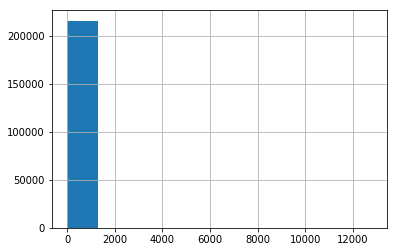

In [18]:
# 查看y的分布情况
df_model['y'].hist()
plt.show

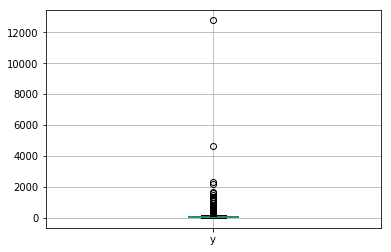

In [19]:
# 查看y的箱线图
df_model[['y']].boxplot()
plt.show()

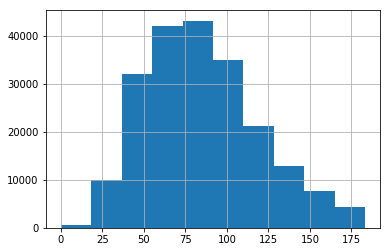

In [20]:
# 根据箱线图的上下限进行异常值的删除
def boxplot_drop(df,colname):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    col = df[colname]
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 删除界限外的异常值
    return (df
            .loc[(df[colname]<u_th)&(df[colname]>l_th),:]
            .reset_index(drop=True))
# 查看异常值删除效果
boxplot_drop(df_model,'y').y.hist()
plt.show()

In [21]:
# 删除异常样本
df_model = boxplot_drop(df_model,'y')
# 删除不需要的特征
df_model = df_model.drop(columns=['total_price','address','sub_station']).fillna(0)
# 输出模型数据
output_path = os.path.join(current_path,'processed_data', f'data_model.csv')
df_model.to_csv(output_path,index=False)

### 使用留一法进行模型训练集和验证集的划分

* 训练集：70%

* 验证集：30%


In [22]:
# 划分数据集
training, testing = train_test_split(df_model, test_size=0.30, random_state=1)

In [23]:
# 划分出自变量与因变量
x_train = training.copy().drop(columns=['id', 'y']).fillna(0)
y_train = training.copy()['y']
x_test = testing.copy().drop(columns=['id', 'y']).fillna(0)
y_test = testing.copy()['y']

In [24]:
# 保存训练集自变量名称
features = x_train.columns.tolist()
x_train.columns

Index(['area', 'is_nan', 'room', 'hall', 'sub_dist', 'subway_500',
       'subway_1000', 'subway_2000', 'bus_500', 'bus_1000', 'bus_2000',
       'sanjia_500', 'sanjia_1000', 'sanjia_2000', 'primary_school_500',
       'primary_school_1000', 'primary_school_2000', 'middle_school_500',
       'middle_school_1000', 'middle_school_2000', 'kindergarten_500',
       'kindergarten_1000', 'kindergarten_2000', 'sub_line_1', 'sub_line_10',
       'sub_line_11', 'sub_line_12', 'sub_line_13', 'sub_line_16',
       'sub_line_17', 'sub_line_2', 'sub_line_3', 'sub_line_4', 'sub_line_5',
       'sub_line_6', 'sub_line_7', 'sub_line_8', 'sub_line_9',
       'sub_line_none'],
      dtype='object')

### 利用参数搜索的Lasso回归模型训练租金预测模型

In [25]:
# 定义lasso回归模型
pipe_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('sc', StandardScaler()),
    ('pwt', PowerTransformer('yeo-johnson')),
    ('lasso_regr', LassoCV(
        alphas=(list(np.arange(1, 11) * 0.1) +
                list(np.arange(1, 20)) +
                list(np.arange(1, 10) * 10)),
        cv=KFold(n_splits=3, shuffle=True),
        n_jobs=-1))
])
# 训练模型
pipe_lasso.fit(x_train, y_train)
print('done')

done


In [26]:
# 保存lasso模型
lasso_path = os.path.join(current_path,'model', f'lasso_model.pkl')
# 保存模型的名称、使用的特征名称、模型、训练数据、预测数据
joblib.dump({'model_name':'lasso_model',
             'feature_list':features,
             'model':pipe_lasso,
             'data':[x_train,y_train,x_test,y_test]}, lasso_path)

['C:\\Users\\wcd\\租金实战forxgboost082andabove\\model\\lasso_model.pkl']

In [27]:
# 定义一个计算mape的函数
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# 检查模型效果
y_test_predict = pipe_lasso.predict(x_test)
print(mean_absolute_error(y_test, y_test_predict))
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape(y_test.astype(float), y_test_predict)
print(mape(y_test.astype(float), y_test_predict))

16.795793490636854
24.22480279960347


### 训练XGBOOST模型训练租金预测模型

此脚本适用于使用xgboost0.82和0.90版本的同学：由于xgboost模型0.81版本和0.82及以上版本差距较大，训练出来的模型相对重要性会有非常大的差距，因此，此版本代码根据0.82版本的模型的训练结果，更新了模型优化策略，修改了样例结果。

In [28]:
# 训练xgboost模型
xgb_model = xgb.XGBRegressor(objective='reg:linear',
                             nthread=8, n_jobs=-1,
                             booster='gbtree', n_estimators=2000,
                             learning_rate=0.05, max_depth=9,
                             colsample_bylevel=1, colsample_bynode=1,
                             colsample_bytree=0.8, base_score=0.5,
                             eval_metric='mae', gamma=0, missing=-999,
                             min_child_weight=11, max_delta_step=0,
                             random_state=0, reg_alpha=0, reg_lambda=1,
                             scale_pos_weight=1, seed=1337, silent=1,
                             subsample=1, verbosity=1)

pipe_xgb = Pipeline([
        ('sc',StandardScaler()),
        ('xgb_rg', xgb_model)
        ])
pipe_xgb.fit(x_train, y_train)
print('done')

done


In [29]:
# 保存xgboost模型
xgb_path = os.path.join(current_path,'model', f'xgb_model.pkl')
joblib.dump({'model_name':'xgb_model',
             'feature_list':features,
             'model':pipe_xgb,
             'data':[x_train,y_train,x_test,y_test]}, xgb_path)

['C:\\Users\\wcd\\租金实战forxgboost082andabove\\model\\xgb_model.pkl']

In [30]:
y_test_predict = pipe_xgb.predict(x_test)
print(mean_absolute_error(y_test, y_test_predict))
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(y_test.astype(float), y_test_predict)
print(mape(y_test.astype(float), y_test_predict))

7.294062864575143
9.961152469903965


### 根据XGBOOST模型的优化

In [31]:
# 使用之前的lasso模型进行简单的集成学习
training['ensemble_lasso'] = pipe_lasso.predict(training.fillna(0).loc[:,features])
testing['ensemble_lasso'] = pipe_lasso.predict(testing.fillna(0).loc[:,features])

In [32]:
# 提取新的训练集和验证集
x_train = training.copy().fillna(0).drop(columns=['id', 'y'])
y_train = training.copy()['y']
x_test = testing.copy().fillna(0).drop(columns=['id', 'y'])
y_test = testing.copy()['y']

集成了lasso模型结果的变量结果

In [35]:
x_train.columns

Index(['area', 'is_nan', 'room', 'hall', 'sub_dist', 'subway_500',
       'subway_1000', 'subway_2000', 'bus_500', 'bus_1000', 'bus_2000',
       'sanjia_500', 'sanjia_1000', 'sanjia_2000', 'primary_school_500',
       'primary_school_1000', 'primary_school_2000', 'middle_school_500',
       'middle_school_1000', 'middle_school_2000', 'kindergarten_500',
       'kindergarten_1000', 'kindergarten_2000', 'sub_line_1', 'sub_line_10',
       'sub_line_11', 'sub_line_12', 'sub_line_13', 'sub_line_16',
       'sub_line_17', 'sub_line_2', 'sub_line_3', 'sub_line_4', 'sub_line_5',
       'sub_line_6', 'sub_line_7', 'sub_line_8', 'sub_line_9', 'sub_line_none',
       'ensemble_lasso'],
      dtype='object')

In [36]:
# 训练新的XGBOOST模型
pipe_xgb.fit(x_train, y_train)
print('done')

done


In [37]:
# 查看模型的表现
y_test_predict = pipe_xgb.predict(x_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mape(y_test.astype(float), y_test_predict))

7.047857318849756
9.569755681903105


In [38]:
# 保存最终模型
from sklearn.externals import joblib 
xgb_ensemble_path = os.path.join(current_path,'model', f'xgb_ensemble_model.pkl')
joblib.dump({'model_name':'xgb_ensemble_model',
             'feature_list':x_train.columns.tolist(),
             'model':pipe_xgb,
             'data':[x_train,y_train,x_test,y_test]}, xgb_ensemble_path)

['C:\\Users\\wcd\\租金实战forxgboost082andabove\\model\\xgb_ensemble_model.pkl']